<a href="https://colab.research.google.com/github/clatonhendricks/Computer-Vision/blob/main/TF-Keras/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.datasets as kfdatasets
from sklearn.preprocessing import LabelBinarizer

import numpy as np

In [ ]:
tf.__version__

'2.8.0'

# Download the Cifar10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test)  = kfdatasets.cifar10.load_data()
(x_train.shape),(y_train.shape),(x_test.shape) ,(y_test.shape)  


170508288/170498071 [==============================] - 11s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

# Preprocess the data

*   Change to float
*   Hot encoding for labels
*   Spilt into validation sets and labels



In [ ]:
#change to float
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

print("INFO: shape of the data:")
print((x_train.shape), (x_test.shape))

#convert integers to labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

#split into validations
x_train, val_images = x_train[10000:], x_train[:10000]
y_train, val_labels = y_train[10000:], y_train[:10000]

print("INFO: Shape of the train and validation split:")
(x_train.shape),(y_train.shape),(val_images.shape), (val_labels.shape)

INFO: shape of the data:
(50000, 32, 32, 3) (10000, 32, 32, 3)
INFO: Shape of the train and validation split


((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

# Sample MiniVGGNet model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
		# first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
	   # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model


In [ ]:
# create the model

def get_cifar_model():
    input = keras.Input(shape=(32*32*3,))
    features = keras.layers.Dense(512,activation='relu')(input)
    features = keras.layers.Dropout(0.5)(features)
    features = keras.layers.Dense(256,activation='relu')(features)
    features = keras.layers.Dropout(0.5)(features)
    outputs = keras.layers.Dense(10, activation='softmax')(features)

    model = keras.Model(input, outputs)

    return model

model = get_cifar_model()



# Build model & compile

In [ ]:
# using customVGGnet

model = MiniVGGNet.build(32,32,3,10)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [ ]:
callback_list = [
                 keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,min_delta=0.001),
                 keras.callbacks.ModelCheckpoint(filepath='checkpoint.keras',monitor='val_accuracy',save_best_only=True)   
]

In [ ]:
from tensorflow.keras.optimizers import SGD

print("[INFO] compiling model...")
opt = SGD(learning_rate=0.01, decay=0.01 / 30, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,                                    
              loss="categorical_crossentropy",                 
              metrics=["accuracy"])                                   
history = model.fit(x_train, y_train,   batch_size=64,                            
          epochs=30,    
          callbacks = callback_list,                                             
          validation_data=(x_test,y_test))                   #val_images, val_labels
test_metrics = model.evaluate(x_test, y_test)               
predictions = model.predict(x_test)  

[INFO] compiling model...
Epoch 1/30
625/625 [==============================] - 27s 25ms/step - loss: 1.7243 - accuracy: 0.4245 - val_loss: 1.8515 - val_accuracy: 0.4023
Epoch 2/30
625/625 [==============================] - 15s 24ms/step - loss: 1.2558 - accuracy: 0.5631 - val_loss: 1.0635 - val_accuracy: 0.6282
Epoch 3/30
625/625 [==============================] - 15s 24ms/step - loss: 1.0569 - accuracy: 0.6294 - val_loss: 1.0007 - val_accuracy: 0.6511
Epoch 4/30
625/625 [==============================] - 15s 23ms/step - loss: 0.9428 - accuracy: 0.6709 - val_loss: 0.8712 - val_accuracy: 0.6996
Epoch 5/30
625/625 [==============================] - 15s 23ms/step - loss: 0.8568 - accuracy: 0.6987 - val_loss: 0.8953 - val_accuracy: 0.6893
Epoch 6/30
625/625 [==============================] - 15s 24ms/step - loss: 0.7995 - accuracy: 0.7177 - val_loss: 0.7705 - val_accuracy: 0.7309
Epoch 7/30
625/625 [==============================] - 15s 23ms/step - loss: 0.7432 - accuracy: 0.7376 - val_lo

# Training & Validation charts

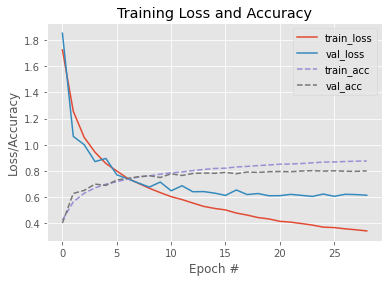

In [ ]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
epoch = len(history.history["loss"])
plt.plot(np.arange(0, epoch), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epoch), history.history["accuracy"], "--", label="train_acc", )
plt.plot(np.arange(0, epoch), history.history["val_accuracy"], "--", label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


The above graph seems like a canonical overfitting behaviour 

- It starts off underfitting the data (train loss & val loss) 
- Roughly around 7-8 epoch seems to be a robust fit
- and then on it shows a typical overfitting example where both training & validation lost seperate 

In [ ]:
test_lose, test_acc =  model.evaluate(x_test,y_test)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 5s 15ms/step - loss: 0.6141 - accuracy: 0.8003
Test accuracy: 0.800
